In [ ]:
from IPython import display
from IPython.core.display import Image


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

In [ ]:
from google.colab import drive
from os import listdir

#drive.mount('/content/gdrive')

In [ ]:
%cd '/content/gdrive/MyDrive/Machine learning II/GP lab'

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/Machine learning II/GP lab'
/content


## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2023

&nbsp;
&nbsp;
&nbsp;
# Lab 4. Gaussian Processes

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Diabetes dataset

[Diabetes](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) is another classic benchmark for regression. Each observation corresponds to a diabetes patient represented by 10 variables and the corresponding target is a score that measures  the disease progression one year after baseline.

The variables that form each observation are:
- age in years

- sex

- bmi body mass index

- bp average blood pressure

- six measures taken from the blood of the patient:
  - s1 tc, T-Cells (a type of white blood cells)

  - s2 ldl, low-density lipoproteins

  - s3 hdl, high-density lipoproteins

  - s4 tch, thyroid stimulating hormone

  - s5 ltg, lamotrigine

  - s6 glu, blood sugar level


In [ ]:

data = pd.read_csv('diabetes.csv', header=0)
data.columns = ['AGE', 'SEX', 'BMI', 'BP','TC','LDL','HDL','TCH','LTG','GLU','Y']
feature_names = data.columns # list with feature names
print("Feature names are")
for ii,fn  in enumerate(feature_names[:-1]):
    print("Column {0:d}: {1}".format(ii,fn))
X = data.values[:,:-1]
Y = data['Y'].values
print("")
print("Loaded {0:d} observations with {1:d} columns".format(X.shape[0], X.shape[1]))
print("Loaded {0:d} targets".format(len(Y)))


Feature names are
Column 0: AGE
Column 1: SEX
Column 2: BMI
Column 3: BP
Column 4: TC
Column 5: LDL
Column 6: HDL
Column 7: TCH
Column 8: LTG
Column 9: GLU

Loaded 442 observations with 10 columns
Loaded 442 targets


In [ ]:
data.describe()

,AGE,SEX,BMI,BP,TC,LDL,HDL,TCH,LTG,GLU,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.642700,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.521877,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


# Splitting into training and test set

Divide the data set into a training set with $3/4$ of the observations.

In [ ]:
from sklearn.model_selection import train_test_split


X = data.drop('Y', axis=1)
y = data['Y']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

# 1. Gaussian Process Regression initial result

Train a Gaussian Process with a composite kernel formed as:

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_c(\mathbf x_i, \mathbf x_j)\times\kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ where
- $\kappa_c(\mathbf x_i, \mathbf x_j)$ is a constant kernel
- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$:
$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$
- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component
$$
\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & \mbox{if } \mathbf x_i== \mathbf x_j \\ 0 & \mbox{otherwise} \end{array}\right.
$$

Choose the following initial parameters for these kernels:
  - RBF kernel:
     - `length_scale`= 1.5
     - `length_scale_bounds` [1e-2, 1e3]
  - White noise kernel:
     - `noise_level`=0.1
     -`noise_level_bounds` [1e-10, 1e6]
     
**Print the performance of the model in the test set.**

**Print the values of the kernel parameters after the GP optimization.**

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.metrics import mean_squared_error as MSE


In [ ]:
def bold(text):
  return "\033[1m" + str(text) + "\033[0m"

def traingp(X_train, X_test, y_train, y_test, kernel, text = "\033[1mResults and optimized parameters\033[0m", verbose=True):
  # Create the Gaussian Process Regressor with the input kernel
  gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
  gp.fit(X_train, y_train)

  # predict test data
  y_pred, sigma = gp.predict(X_test, return_std=True)
  mse = MSE(y_test, y_pred)
  if verbose:
    print(text)
    print(f"\nMean Squared Error on Test Set: {mse}")
    optimized_params = gp.kernel_.get_params()
    print(f"Constant Kernel: {optimized_params['k1__k1']}")
    print(f"RBF Kernel.Length Scale: {optimized_params['k1__k2__length_scale']}")
    print(f"White Noise Kernel.Noise Level: {optimized_params['k2__noise_level']}")

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

# defining composite kernel
kernel = (ConstantKernel() * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e3)) +
          WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6)))
traingp(X_train, X_test, y_train, y_test, kernel)

Results and optimized parameters

Mean Squared Error on Test Set: 3048.674806066812
Constant Kernel: 316**2
RBF Kernel.Length Scale: 163.6936143949801
White Noise Kernel.Noise Level: 3140.158915033035


The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


### Your comments:

**Discuss about the differences between the kernel parameters before and after optimizing the GP.**

The composite kernel uses the RBF to capture the smooth and continuous variations in the data, the Constant Kernel accounts for bias in the data and the White Noise kernel is used to account for uncorrelated noise in the data. The combination results in a flexible kernel.

Gaussian processes are sensitive to initialization, depending upon where the procedure is initialized, it may converge to a different local minima of MSE, greatly hindering the overall performance of the model.

EXTEND


# 2. Strategies to improve the initial result

In this assignment we are going to explore three strategies to improve this initial result

1. Scaling the data
2. Feature selection
3. Kernel design

## 2.1 Scaling the data

Repeat the experiment that produced the baseline result scaling the observations with a `MinMaxScaler` and evaluate the impact of this scaling in the performance of the GP.

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_trains, X_tests, y_trains, y_tests = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
traingp(X_trains, X_tests, y_trains, y_tests, kernel, bold("Optimized parameters and results on scaled data"))




Optimized parameters and results on scaled data

Mean Squared Error on Test Set: 2727.1617860854785
Constant Kernel: 277**2
RBF Kernel.Length Scale: 3.6701963424384556
White Noise Kernel.Noise Level: 2930.87035702451


### Your comments:

**Did scaling improve the accuracy of the GP?**

Indeed it affected positively the accuracy of the regressor, as the MSE decreases significantly, in fact the MSE decrease is of 10%, which is very significant.



**Did scaling affect to the final value of the kernel parameters after the optimization?**

As expected it did. We went over before on the sensitivity of the Gaussian process to initialization, however the same is true for scaling. Firstly, a main part of the composite kernel is the RBF kernel which we know from previous labs to be sensitive to scaling because of the effect of distance metrics in the computation.

In the same manner the added noise with the White Noise Kernel affects the results differently as it impacts the map on a different amount. Gaussian processes perform optimization by adjusting the kernel hyperparameters to maximize the likelihood of the observed data, by scaling the optimal values are expected to change as demonstrated by this example.



## 2.2 Feature selection

The goal in this strategy is to study
- if any of the variables is noisy (its presence worsens the performance of the regressors)
- if any of the variables is not relevant (its presence or absence does not affect the performance of the regressor, hence you could save resources by skipping its measure
- if some of these variables are more critical than the others in the conformation of the score. This way you can gain insights about the main drivers of the disease.

We will explore two strategies to perform the feature selection

1. Random Forests property `feature_importances_`.  

2. GP with an ARD kernel



### 2.2.1 Random Forests `feature_importances_`

In Random Forest the variables are individually selected to design the stump test in each branch node of each tree in the forest. Relevant variables will be in general oftenly selected for these test, while noisy or redundant variables will be selected less oftenly.  Besides, since the growing of each tree only considers a subset of the training data, the left-out subset can be used as validation set to evaluate the quality of each stump. In this sense, the most relevant variables will lead to better quality stumps.

In the sklearn implementation of Random Forest there is a property `feature_importances_` that is precisely a score in the relevance of the features.


In the following cell write code that
 1. Train a Random Forest Regressor with its hyperparameters selected by cross-validation within the following  ranges
  - number of trees: 10, 20, 50, 100, 200, 500, 1000
  - maximum number of leaves per node: 5, 10, 20, 50
  
 2. Print the score in the test set  of the Random Forest fitted with the best set of hyperparameters

 3. Print the value of `feature_importances_` for each feature in the data set

 4. Sort the features in order of decreasing importance in an array called `random_forest_order`



The following two code cells are included to illustrate an example and put more into context the performance of the Gaussian Regressor in the realm of other machine learning algorithms.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from  sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


def tknn(X_train, X_test, y_train, y_test, param_grid, text="Results of KNN on original dataset", verbose=True):
    knn = KNeighborsRegressor()

    # Create a pipeline with the GridSearchCV step
    pipeline = Pipeline([
        ('grid_search', GridSearchCV(estimator=knn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5))
    ])

    # Fit the pipeline to the training datac
    pipeline.fit(X_train, y_train)

    # Get the best KNN model from the pipeline
    best_knn = pipeline.named_steps['grid_search'].best_estimator_

    if verbose:
        print(text)
        print(f"Best Parameters: {pipeline.named_steps['grid_search'].best_params_}")
        y_pred = best_knn.predict(X_test)
        mse = MSE(y_test, y_pred)
        print(f"Test Score (MSE): {mse:.3f}\n")

    return best_knn, mse

In [ ]:
param_grid = {
    'n_neighbors': [1,2,3,4,5,6,7,8],
}

tknn(X_train, X_test, y_train, y_test, param_grid)

Results of KNN on original dataset
Best Parameters: {'n_neighbors': 7}
Test Score (MSE): 4128.769



(KNeighborsRegressor(n_neighbors=7), 4128.768891340321)

ACTUAL ANSWER

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

from sklearn.ensemble import RandomForestRegressor


def trainrf(X_train, X_test, y_train, y_test, param_grid, text=bold("Results of random forest on original dataset"), verbose=True):
    rf = RandomForestRegressor(random_state=42)

    # Create a pipeline with the GridSearchCV step
    pipeline = Pipeline([
        ('grid_search', GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5))
    ])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Get the best Random Forest model from the pipeline
    best_rf = pipeline.named_steps['grid_search'].best_estimator_

    if verbose:
        print(text)
        print(f"Best Parameters: {pipeline.named_steps['grid_search'].best_params_}")
        print(f"Test Score (MSE): {best_rf.score(X_test, y_test):.3f}\n")

    # Get feature importances
    feature_importances = best_rf.feature_importances_
    feature_names = X_train.columns
    sorted_indices = np.argsort(feature_importances)[::-1]

    return best_rf, feature_importances[sorted_indices], feature_names[sorted_indices]




In [ ]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000],
    'max_leaf_nodes': [5, 10, 20, 50]
}

# Call the trainrf function
best_rf, feature_importances, feature_names = trainrf(
    X_train, X_test, y_train, y_test, param_grid,
    text=bold("Results of random forest on regular data"), verbose=True
)

best_rfs, feature_importancess, feature_names = trainrf(
    pd.DataFrame(X_trains), pd.DataFrame(X_tests), y_trains.ravel(), y_tests.ravel(), param_grid,
    text=bold("Results of random forest on scaled data"), verbose=True
)

Results of random forest on regular data
Best Parameters: {'max_leaf_nodes': 20, 'n_estimators': 1000}
Test Score (MSE): 0.493

Results of random forest on scaled data
Best Parameters: {'max_leaf_nodes': 20, 'n_estimators': 500}
Test Score (MSE): 0.464



In [ ]:
fdic = {fnames: feature_importances[idx] for idx,fnames in enumerate(X_train.columns)}
fdics = {fnames: feature_importancess[idx] for idx,fnames in enumerate(X_train.columns)}

In [ ]:
sorted_features = dict(sorted(fdic.items(), key=lambda item: item[1], reverse=True))
sorted_featuress = dict(sorted(fdics.items(), key=lambda item: item[1], reverse=True))

In [ ]:
print(bold('Feature importance for Random Forest trained with regular data'))
for idx, n in enumerate(sorted_features.items()):
  print(f"{idx + 1}. {n[0]}: {n[1]}")

Feature importance for Random Forest trained with regular data
1. AGE: 0.4130641607516948
2. SEX: 0.2426717688352441
3. BMI: 0.10260910066767487
4. BP: 0.05285618226391051
5. TC: 0.04509298633713433
6. LDL: 0.044640444766349215
7. HDL: 0.038621220255372575
8. TCH: 0.03357927082518025
9. LTG: 0.02147523844970245
10. GLU: 0.005389626847736814


In [ ]:
print(bold('Feature importance for Random Forest trained with scaled data'))
for idx, n in enumerate(sorted_featuress.items()):
  print(f"{idx + 1}. {n[0]}: {n[1]}")

Feature importance for Random Forest trained with scaled data
1. AGE: 0.41122190351063137
2. SEX: 0.2812577744893478
3. BMI: 0.080816405342994
4. BP: 0.05339511346861186
5. TC: 0.04441666396426023
6. LDL: 0.03832040218860053
7. HDL: 0.03324260428022725
8. TCH: 0.0327177265291064
9. LTG: 0.0196371447104354
10. GLU: 0.004974261515785235


In [ ]:
diffp = {key: abs((sorted_features[key] - sorted_featuress[key]) / ((sorted_features[key] + sorted_featuress[key]) / 2.0)) * 100 for key in sorted_features.keys()}

In [ ]:
diff = {key: abs(sorted_features[key] - sorted_featuress[key]) for key in sorted_features.keys()}
print(bold("Absolute difference on feature weights between scaled an unscaled data"))
for idx, n in enumerate(diff.items()):
  print(f"{idx + 1}. {n[0]}: {round(n[1],4)}, {round(diffp.get(n[0]), 2)}%")

Absolute difference on feature weights between scaled an unscaled data
1. AGE: 0.0018, 0.45%
2. SEX: 0.0386, 14.73%
3. BMI: 0.0218, 23.76%
4. BP: 0.0005, 1.01%
5. TC: 0.0007, 1.51%
6. LDL: 0.0063, 15.24%
7. HDL: 0.0054, 14.97%
8. TCH: 0.0009, 2.6%
9. LTG: 0.0018, 8.94%
10. GLU: 0.0004, 8.02%


### Your comments:

**Did RF perform in the test set better than GP?**

It performed much better than the Gaussian Process, as the MSE went from 2700 to 0.45, this demonstrates the importance of correct initialization of parameters in the Gaussian process.

It is also important to note that the comparison being made is to a very powerful model like random forest, having also used grid search to tune the hyperparameters which result in a very low MSE, compared to our GP, where the initialization is on arbitrary values.

We observed however that our far from optimized Gaussian process soundly outperforms a KNN regressor.



**What are the more relevant features according to RF?**

The most relevant features Random Forest detects are the same irrespective to if it is trained with the regular data or the scale data. The  three most relevant features are age, sex and body max index, the complete list with the coefficients is shown above.

**Are there significant differences in relevance among the features?**

The differences are minor, specially since the magnitude of the weights is very small. The highest relative differences observed are for the BMI, LDL and HDL attributes which are of 23.76%, 15.2% and 14.9%. The complete breakdown is shown above.
___


#### Shap value ranking

There exists a wide array of alternatives to test feature importance, we will now use the Shapley values and observe the results using feature ranking based on them.

The Shapley value of a feature is the average contribution of that feature across all possible coalitions (combinations of features). It quantifies how much each feature contributes to the difference between the prediction for a specific set of features and the expected prediction when all features are considered. The Shapley value of a filter $i$ is given by,


$$
\Phi(i) = \sum \left[ \frac{m!(N-m-1)!}{N!} \right] \left[ f(C \cup \{i\}) - f(C) \right]
$$

In [ ]:
! pip install shap

In [ ]:
import shap

def shapvals(X_train, X_test, y_train, y_test, model, test_size=0.2, random_state=42):
    model.fit(X_train, y_train)
    # Initialize the SHAP explainer
    explainer = shap.Explainer(model, X_train)
    # Calculate Shapley values for all features
    shapley_values = explainer.shap_values(X_test)
    mean_shapley_values = np.mean(np.abs(shapley_values), axis=0)
    shapley_dict = {feature: shapley_value for feature, shapley_value in zip(X_test.columns, mean_shapley_values)}
    # Sort the dictionary by Shapley values in descending order
    shapley_dict = dict(sorted(shapley_dict.items(), key=lambda item: item[1], reverse=True))

    return shapley_dict

In [ ]:
foshap = shapvals(X_train, X_test, y_train, y_test, best_rf)

In [ ]:
print(bold('Feature importance with regular data explained using Shap values under random forest'))
for idx, n in enumerate(foshap.items()):
  print(f"{idx + 1}. {n[0]}: {n[1]}")

Feature importance with regular data explained using Shap values under random forest
1. BMI: 24.74902704122058
2. LTG: 19.99458077597892
3. BP: 11.096259203537414
4. HDL: 4.788007685396319
5. AGE: 2.973796400045378
6. GLU: 2.7474537534089505
7. TCH: 2.1326834381081685
8. TC: 1.8301580070205996
9. LDL: 1.3230322480017558
10. SEX: 0.992052502774032


In [ ]:
foshaps = shapvals(pd.DataFrame(X_trains), pd.DataFrame(X_tests), y_trains.ravel(), y_tests.ravel(), best_rfs)

In [ ]:
print(bold('Feature importance with scaled explained using Shap values under random forest'))
for idx, n in enumerate(foshap.items()):
  print(f"{idx + 1}. {n[0]}: {n[1]}")

Feature importance with scaled explained using Shap values under random forest
1. BMI: 24.74902704122058
2. LTG: 19.99458077597892
3. BP: 11.096259203537414
4. HDL: 4.788007685396319
5. AGE: 2.973796400045378
6. GLU: 2.7474537534089505
7. TCH: 2.1326834381081685
8. TC: 1.8301580070205996
9. LDL: 1.3230322480017558
10. SEX: 0.992052502774032


The Shapvals give a noticeably different ordering of feature importance than the built-in feature importance from random forest, note that in this case the feature importance is independent on whether the model has been trained with scaled data or not.

-----------
In the next cell write code that implements a `for loop` that in each iteration trains a GP with the settings of Section 1 but increasing the number of features in the ordering suggested by `random_forest_order`.

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 

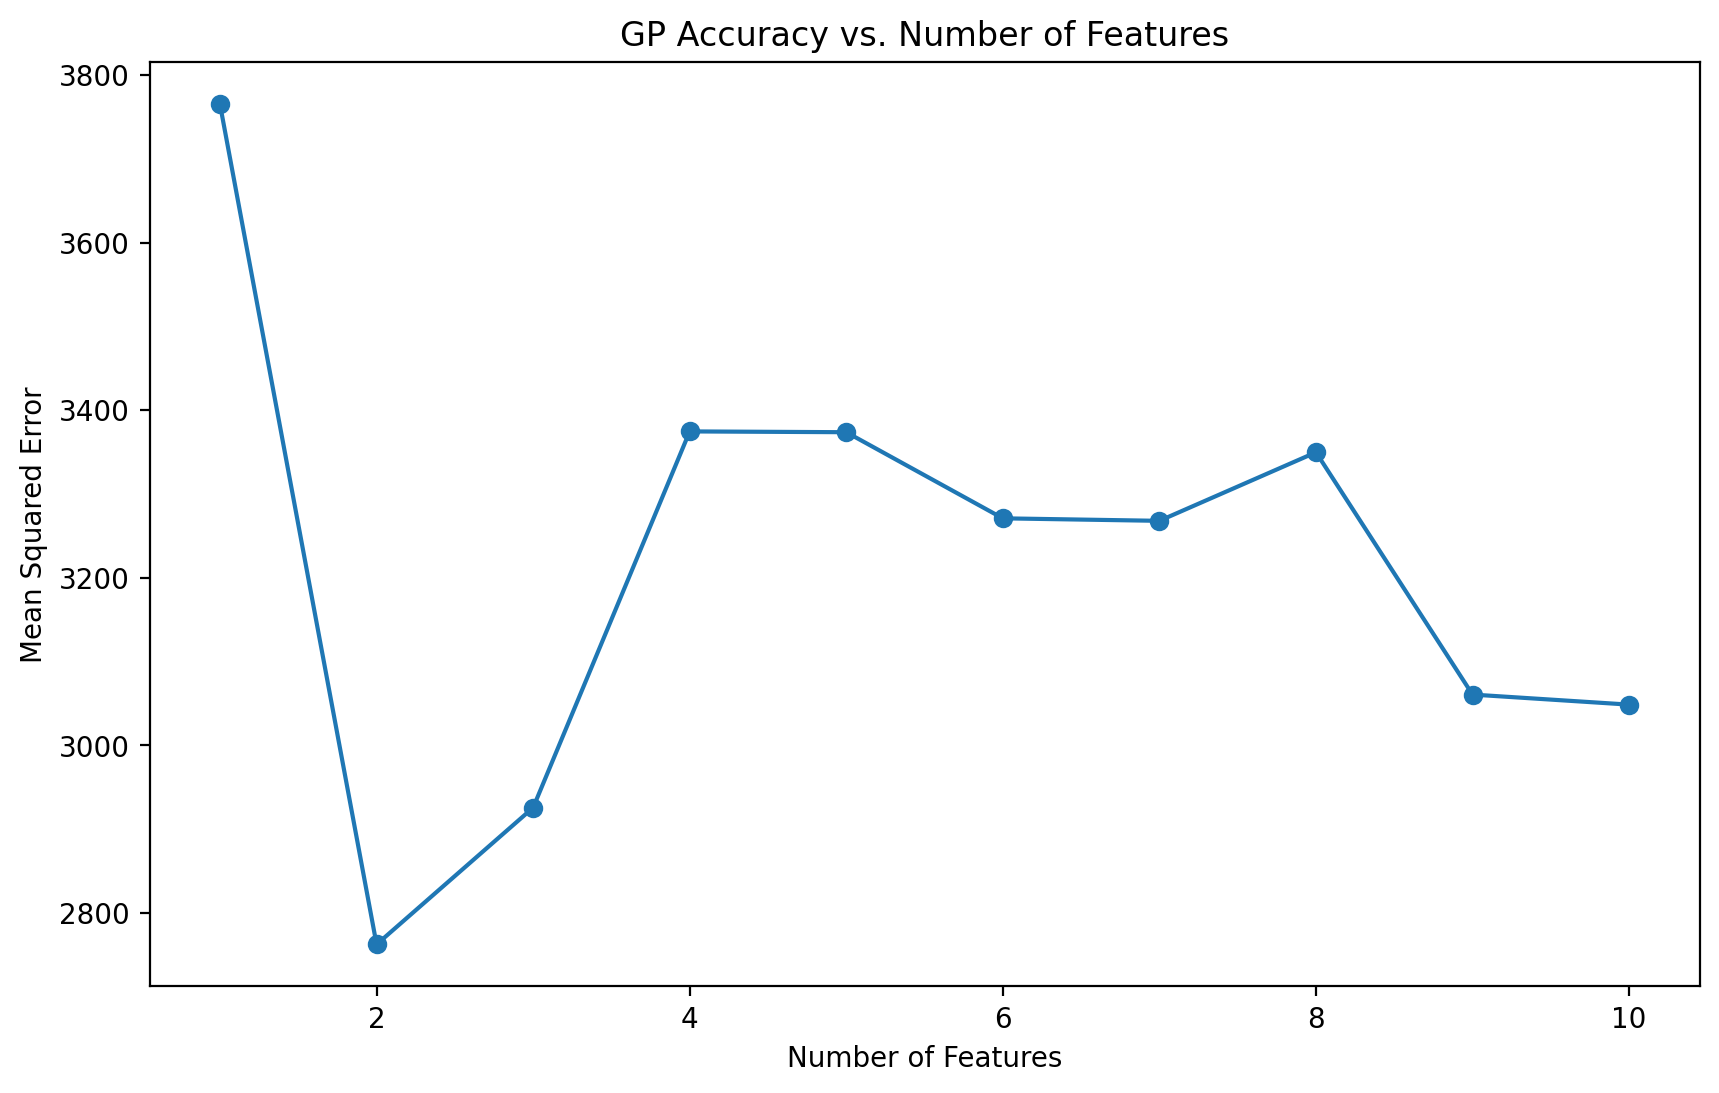

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming you have a list random_forest_order with feature importance order
random_forest_order = ['BMI', 'LTG', 'BP', 'HDL', 'AGE', 'GLU', 'TCH', 'TC', 'LDL', 'SEX']

# Initialize a list to store the test accuracies
test_accuracies = []

# Iterate through increasing number of features
for i in range(1, len(random_forest_order) + 1):
    # Select the top i features
    selected_features = random_forest_order[:i]
    # Get the corresponding indices of selected features
    # print("Selected features: " + str(selected_features))
    feature_names = X_train.columns
    selected_indices = [list(feature_names.tolist()).index(feature) for feature in selected_features]

    # Subset the training and testing data
    X_train_subset = X_train.iloc[:, selected_indices]
    X_test_subset = X_test.iloc[:, selected_indices]

    # Fit and evaluate the GP model
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(X_train_subset, y_train)
    y_pred_subset = gp.predict(X_test_subset)
    score_subset = mean_squared_error(y_test, y_pred_subset)
    test_accuracies.append(score_subset)

# Plot the GP accuracy vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(random_forest_order) + 1), test_accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.title('GP Accuracy vs. Number of Features')
plt.show()


### Your comments:

**What is the best number of features to model the problem?**
The best number of features to model the problem is two features, since this amount implies the lowest Mean Sqaured Error

It is also noticeable that there is not a huge difference between the usage of the best pair of features rather than choosing up to three, which are, respectively, BMI, LTG and BP. The usage of four features increases drastically, since the usage of a noticeably less important feature as it is HDL provoke an increase on possible effects of overfitting

**Does removing features improve the performance of RF?**

Definitely. As exposed on the question above, the insertion of noticeably less important features implies a raise in MSE, and thus, a decrease in accuracy. As said above, overfitting may be the main reason why this happens, as well as a possible increase of redundancy on features

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**

We consider noisy features to be the ones that increase the MSE since the selection of the fourth most important feature. This provokes a raise of nearly 500 to 600 points in MSE, and since the importance of the features constantly falls, since the fourth feature we consider since the fourth feature onwards are considered to be noisy features

### 2.2.2 GP with an ARD kernel

The fitting of a GP endowed with an anisotropic RBF kernel obtains a different value of the `length_scale` for each variable.

**Relate the length scale of each variable with its relevance in the predictive function**

Hint: Consider how does the output of the predictive function changes as the value of a certain variable $x_k$ changes depending on $l_k^2$.

In the next cell write code that fits a GP with an ARD kernel.

**Print the lengthscale value of each feature after the kernel has been optimized** Hint, learn to use `kernel_get_params()`.**

**Sort the features in order of decreasing importance in an array called `ARD_order`**

**Print the score in the test set  of the GP with ARD kernel**

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############
from sklearn.metrics import mean_squared_error, r2_score

# Define the ARD kernel with a separate length scale for each feature.
kernel = RBF(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2))

# Fit the GP model with the ARD kernel.
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)

y_pred = gp.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")
print("GP score")
print(gp.score(X_test, y_test))

# lenght scales
length_scales = gp.kernel_.theta
#params
print("params")
print(gp.kernel_.get_params())




Mean Squared Error: 6356.013320129154
R-squared: -0.1494339741328805
GP score
-0.1494339741328805
params
{'length_scale': array([ 11.04060697,   0.96643705,   8.70651176,   2.93086577,
       100.        ,  81.34985644,  17.76150723,  10.45864966,
         0.69312858,  19.92447485]), 'length_scale_bounds': (0.01, 100.0)}


The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.


In [ ]:

# total sum of lenght scale
total_length_scale = np.sum(length_scales)

# store feature names, length scales, and relevance values
feature_names = X_train.columns.tolist()
feature_length_scales = length_scales.tolist()

# Calculate the proportion of each feature's length scale to the total length scale
feature_relevance = length_scales / total_length_scale

# Create a list of list containing feature name, length scale, and relevance
feature_info = [(feature_names[i], feature_length_scales[i], feature_relevance[i]) for i in range(len(feature_names))]

# Sort the feature info list by relevance
ARD_order = sorted(feature_info, key=lambda item: item[2], reverse=True)

# Print the feature info to display both length scales and relevance
for feature, length_scale, relevance in ARD_order:
    print(f"Feature: {feature}, Length Scale: {length_scale:.2f}, Relevance: {relevance:.2%}")

print(ARD_order)


Feature: AGE, Length Scale: 9.90, Relevance: 28.40%
Feature: LDL, Length Scale: 4.61, Relevance: 13.21%
Feature: TCH, Length Scale: 4.61, Relevance: 13.21%
Feature: SEX, Length Scale: 2.81, Relevance: 8.05%
Feature: BP, Length Scale: 2.73, Relevance: 7.83%
Feature: TC, Length Scale: 2.35, Relevance: 6.73%
Feature: HDL, Length Scale: 2.04, Relevance: 5.86%
Feature: LTG, Length Scale: 1.05, Relevance: 3.00%
Feature: BMI, Length Scale: 0.46, Relevance: 1.32%
Feature: GLU, Length Scale: 0.24, Relevance: 0.69%
[('AGE', 9.89931574574679, 0.284014347122533), ('LDL', 4.605170185988092, 0.13212371817956323), ('TCH', 4.605170185988092, 0.13212371817956323), ('SEX', 2.8073535506323837, 0.08054381800757805), ('BP', 2.7294686684078684, 0.07830927730356879), ('TC', 2.3453868671634948, 0.06728985486834288), ('HDL', 2.0439249190192177, 0.058640820876142974), ('LTG', 1.0471448304528346, 0.030042900236976082), ('BMI', 0.4607323923626579, 0.013218550956039993), ('GLU', 0.23906240950743526, 0.006858772454

In the next cell write code that implements a `for loop` that in each iteration trains a GP with an ARD kernel but increasing the number of features in the ordering suggested by `ARD_order`.

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

MSE 6722.649539426913 feature: 1
score -0.21573719053330098 feature: 1
r2 -0.21573719053330098 feature: 1


lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MSE 19397.42921745857 feature: 2
score -2.5078693247501884 feature: 2
r2 -2.5078693247501884 feature: 2
MSE 14590.675339472102 feature: 3
score -1.6386064811442607 feature: 3
r2 -1.6386064811442607 feature: 3
MSE 12850.161170704801 feature: 4
score -1.3238484689631074 feature: 4
r2 -1.3238484689631074 feature: 4
MSE 10005.304290901695 feature: 5
score -0.8093789446725403 feature: 5
r2 -0.8093789446725403 feature: 5
MSE 8303.636922644386 feature: 6
score -0.501646064448102 feature: 6
r2 -0.501646064448102 feature: 6
MSE 8317.997742618305 feature: 7
score -0.504243103431981 feature: 7
r2 -0.504243103431981 feature: 7
MSE 7111.222794026974 feature: 8
score -0.2860075436274667 feature: 8
r2 -0.2860075436274667 feature: 8
MSE 26673.1901687068 feature: 9
score -3.8236322729726036 feature: 9
r2 -3.8236322729726036 feature: 9
MSE 7976.8315266327545 feature: 10
score -0.4425459326223735 feature: 10
r2 -0.4425459326223735 feature: 10


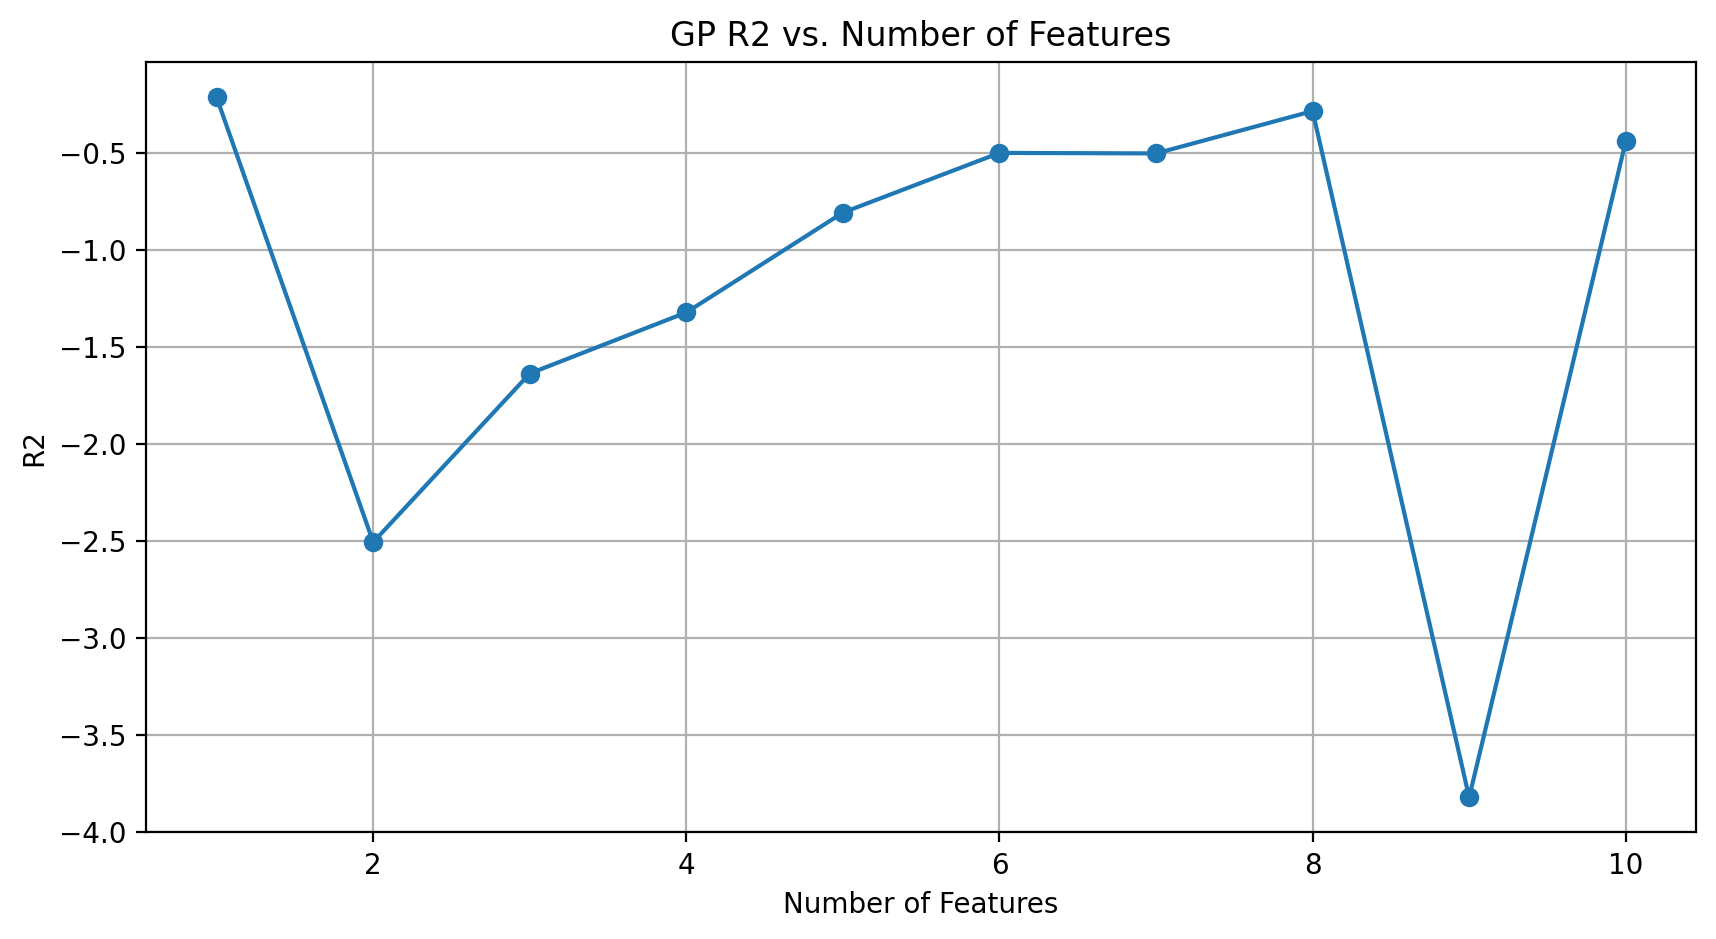

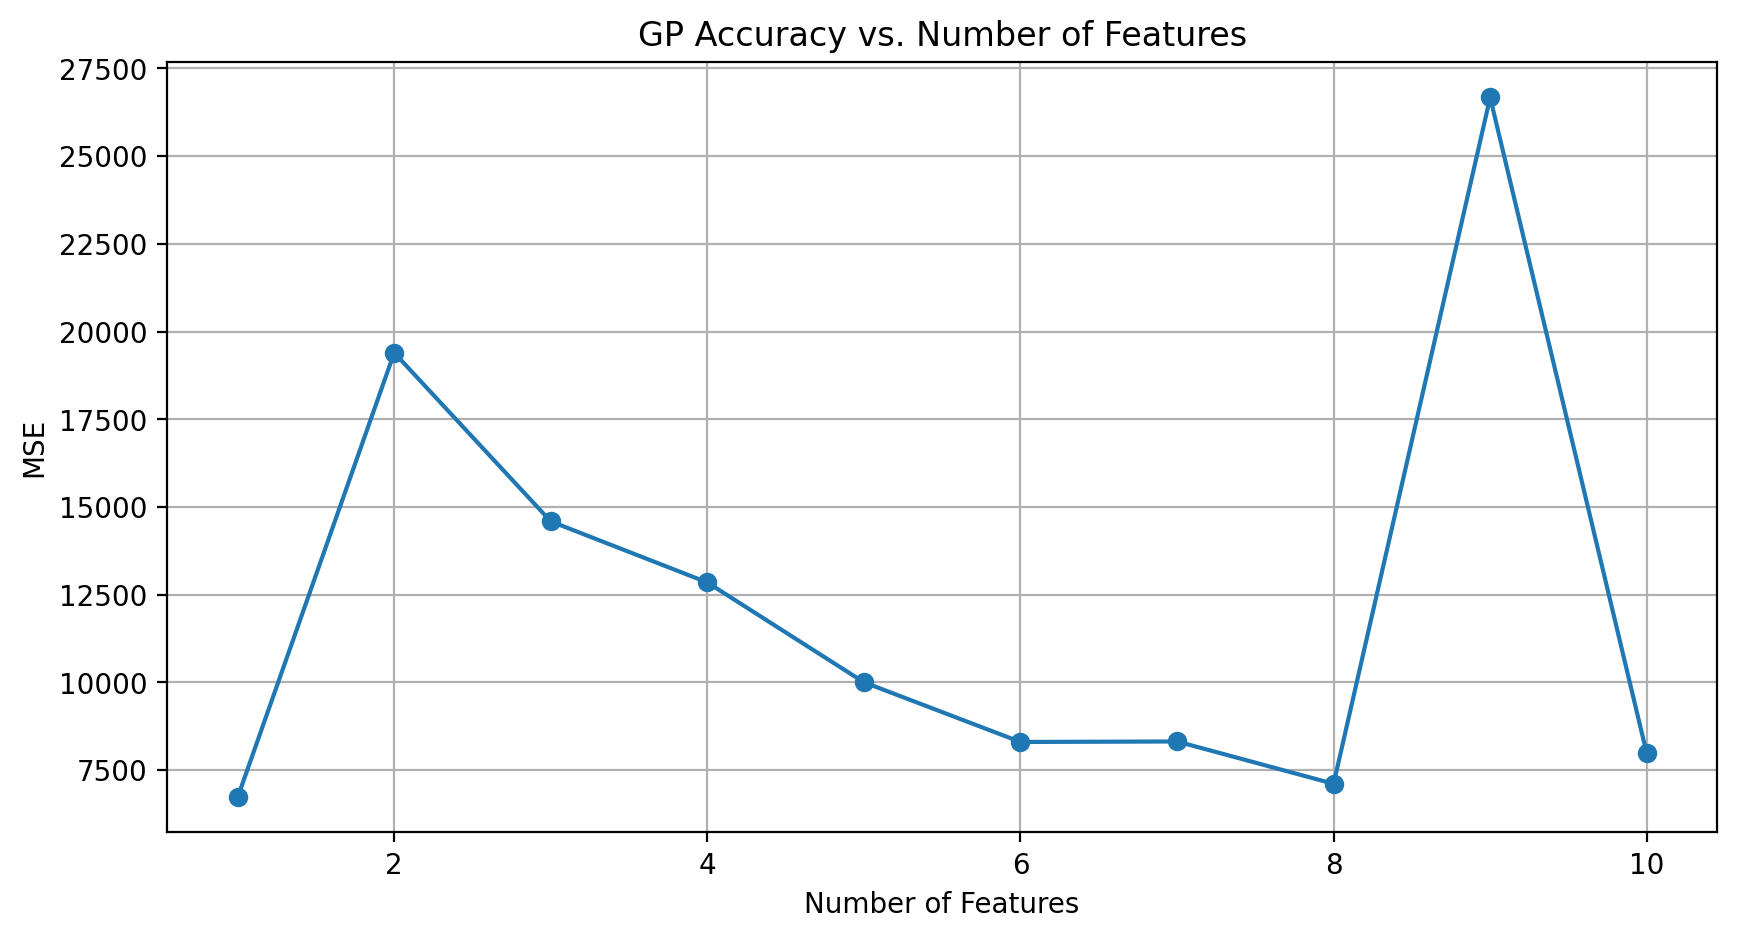

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############


num_features_used = []  # Number of features used in each iteration
mse_scores = []         # Mean squared error (accuracy) for each GP model
r2_scores = []

# Create a for loop to train GPs with increasing features
for feature, length_scale, _ in ARD_order:
    num_features = len(num_features_used) + 1  # Increment the number of features used
    selected_features = [feature for feature, _, _ in ARD_order[:num_features]]
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Define and train the GP model
    kernel = RBF(length_scale=np.ones(num_features))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_train_selected, y_train)

    # Make predictions on the test set
    y_pred = gp.predict(X_test_selected)

    # Calculate mean squared error (MSE) as a measure of accuracy
    mse = mean_squared_error(y_test, y_pred)
    score = gp.score(X_test_selected, y_test)
    r2 = r2_score(y_test, y_pred)
    print("MSE", mse, "feature:",num_features )
    print("score", score, "feature:",num_features )
    print("r2", r2, "feature:",num_features )

    # Store results
    num_features_used.append(num_features)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Plot the GP R2 vs. the number of features
plt.figure(figsize=(10, 5))
plt.plot(num_features_used, r2_scores, marker='o', linestyle='-')
plt.xlabel("Number of Features")
plt.ylabel("R2")
plt.title("GP R2 vs. Number of Features")
plt.grid(True)
plt.show()

# Plot the GP accuracy vs. the number of features
plt.figure(figsize=(10, 5))
plt.plot(num_features_used, mse_scores, marker='o', linestyle='-')
plt.xlabel("Number of Features")
plt.ylabel("MSE")
plt.title("GP Accuracy vs. Number of Features")
plt.grid(True)
plt.show()


### Your comments:

**What is the best number of features to model the problem according to the ARD kernel?**



**How stable are the optimizations of the Gaussian Processes with ARD kernels as the number of features increase?**


**Does removing features improve the performance of GPs?**

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**

**How does the feature selection suggested by the ARD kernel compare with that suggested by random forest?**

1: According to our results, the best number of feature to use, thus the smallest MSE and the highest R2 scores, is 8 or 1.

2 : Not really stable, there is not a pattern. We can see that from 1 to 2 the MSE has big increase, it tends to stay high until it decrease on 6 number of features, then it increase at 7, then it lowers at 8 and then it jumps again at 9 and 10. While for the R2 scores it follows the opposite trends as MSE.

3: In our case considering all the variales we found a Mean Squared Error of 7200. The lowest MSE we found doung this sort of feature selection was 6204. Regarding R2 scores, with all features the R2 score was -0.312, while the best one found during the feature selection phase appears to be -0.122 with 8 features. So comparable results, but a small improvment have been seen.

4: The 2 feature that increase the most the MSE and reduce the most R2 are the second and the ninth one, which would equate to HDL and LDL.

5: for ARD feature selection the best number of features is 8, while for Random Forest feature selection the best number of feature is 2. Altough we have to say that the second best result in term of MSE and R2 in ARD was to use 2 features. But in the random forest, using 8 features was not a viable solution.

# 4. Exploring sophisticate kernels for the GP

The greatest potentiality of GPs are the exploration of different kernels that capture the geometry of the inputs.

Besides, the essential kernels can be combined into more sophisticate ones using the addition and multiplication operations.

And the most interesting feature, the GP implementation is able to optimize the parameters of the kernel maximizing the likelihood of the observations, what saves the crossvalidation step for optimizing parameters.

Read the [section 1.7.5 of this site](https://scikit-learn.org/stable/modules/gaussian_process.html) to learn the different kernels that are implemented in the scikit learn distribution of Gaussian Processes.

In this section check at least twenty different kernel configurations and evaluate if they improve the kernel evaluated in section 1. Remember this kernel was

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_c(\mathbf x_i, \mathbf x_j)\times\kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ where
- $\kappa_c(\mathbf x_i, \mathbf x_j)$ is a constant kernel
- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$:
$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$
- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component
$$
\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & \mbox{if } \mathbf x_i== \mathbf x_j \\ 0 & \mbox{otherwise} \end{array}\right.
$$

Within the kernel combinations to explore you can include:
1. Replace $\kappa_r(\mathbf x_i, \mathbf x_j)$ by an anisotropic RBF in $\kappa_1(\mathbf x_i, \mathbf x_j)$.

3. Individual kernels presented in the lecture

4. Addition of several kernels

5. Multiplication of several kernels

6. Use your imagination!

We will use the different kernel combinations to characterize how difficult is the problem at hand in terms of how difficult is to find out a kernel that achieves the best possible result in the test set.

For this purpose:
1. Group in a same array all the scores in the **test set** achieved by all the kernel combinations that you explore in this section. Consider carrying out this exploration in a programatic fashion. As a suggestion, program nested loops that create composite kernels as combination of simple kernels.

2. Discuss about the range of test accuracies that can be reached with GPs when the kernel is more carefully designed. Depending on the number of different kernels explored you might consider adding to your discussion
- minimum, maximum, mean values
- standard deviations
- percentiles
- histogram

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF # Simple Kernels
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, ExpSineSquared, DotProduct # Advanced Kernels
from sklearn.gaussian_process.kernels import Sum, Exponentiation, Product # Kernel Operators
from sklearn.metrics import r2_score
import numpy as np

In [ ]:
def model_mse(kern, rests=10):
  model = GaussianProcessRegressor(kernel=kern,n_restarts_optimizer=rests,random_state=0).fit(X_trains, y_trains)
  y_pred = model.predict(X_tests)
  return r2_score(y_tests, y_pred)

In [ ]:
kernels = [ConstantKernel,RBF,Matern,RationalQuadratic,ExpSineSquared,DotProduct]

k_params = [
    {'constant_value':1.0, 'constant_value_bounds':(1e-6, 1e8)},
    {'length_scale':1.0, 'length_scale_bounds':(1e-6, 1e8)},
    {'length_scale':1.0, 'length_scale_bounds':(1e-6, 1e8), 'nu':1.5},
    {'length_scale':1.0, 'length_scale_bounds':(1e-6, 1e8)},
    {'length_scale':1.0, 'length_scale_bounds':(1e-6, 1e8), 'periodicity':1, 'periodicity_bounds':(1e-6, 1e8)},
    {'sigma_0':1.0, 'sigma_0_bounds':(1e-6, 1e8)}
]

len_k = len(kernels)
comb = np.math.factorial(len_k) / (np.math.factorial(2) * np.math.factorial(len_k - 2))
test_scores = np.zeros(int(2 * comb + len_k))
idx = 0

In [ ]:
# Loop over kernels to create combinations

for i in range(len_k):

  # Exponential Kernel - Squared
  n1 = WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6))
  k1 = kernels[i](**k_params[i])
  test_scores[idx] = model_mse(Exponentiation(k1 + n1, exponent=2) + n1)
  idx += 1

  for j in range(i+1, len_k):
    # Sum of Kernels
    n2 = WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6))
    k2 = Sum(kernels[i](**k_params[i]), kernels[j](**k_params[j]))
    test_scores[idx] = model_mse(k2 + n2)
    idx += 1

    # Product of Kernles
    n3 = WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6))
    k3 = Product(kernels[i](**k_params[i]), kernels[j](**k_params[j]))
    test_scores[idx] = model_mse(k3 + n3)
    idx += 1

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimensi

In [ ]:
test_scores

array([-1.16279109e-02, -1.16279096e-02,  4.85261736e-01, -1.16278220e-02,
        5.00792978e-01, -1.16240706e-02,  4.95471095e-01, -1.17361532e-02,
       -1.11800278e-02, -5.57974261e-03,  4.55197207e-01, -3.91033122e+00,
       -3.80961533e+00, -3.91033126e+00, -3.80961538e+00, -3.91033126e+00,
       -3.80961536e+00, -3.91033126e+00, -1.57545154e-03,  4.85263497e-01,
       -3.91033122e+00, -3.80961533e+00, -3.91033126e+00, -3.80961534e+00,
       -3.91033126e+00, -5.57974055e-03,  5.00793296e-01, -3.91033126e+00,
       -3.80965205e+00, -3.91036804e+00, -5.57791066e-03,  4.95464549e-01,
       -3.91033126e+00, -1.76279939e-03,  4.59271505e-01,  4.56396587e-01])

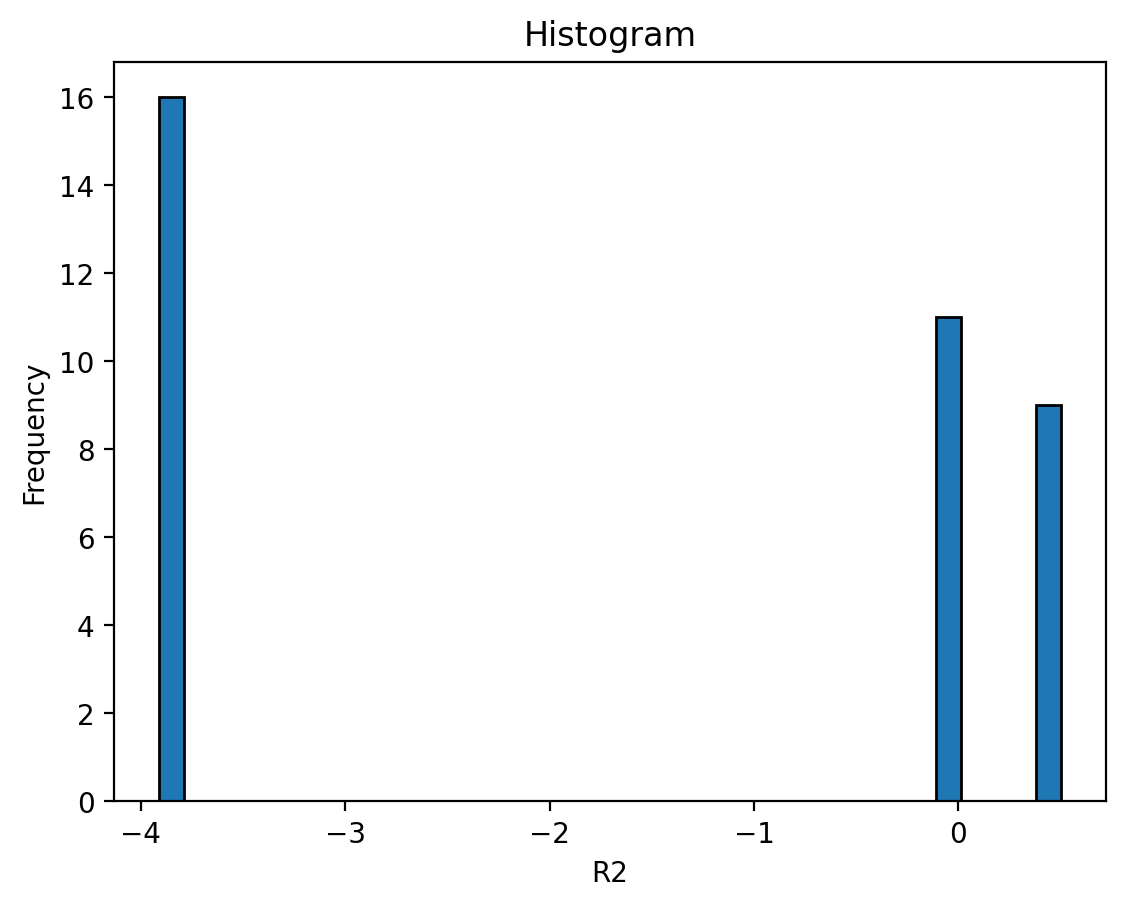

Minimum: -3.9103680415669126
Maximum: 0.500793295747087
Mean: -1.6032406994199988
Median: -0.011627910261178709
Standard Deviation: 2.0381339450954306
25th Percentile: -3.9103312222110764
50th Percentile: -0.011627910261178709
75th Percentile: 0.11261771300216777
90th Percentile: 0.49036402287567143


In [ ]:
# Calculate minimum, maximum, mean values
minimum = np.min(test_scores)
maximum = np.max(test_scores)
mean = np.mean(test_scores)
median = np.median(test_scores)

# Calculate standard deviation
std_dev = np.std(test_scores)

# Calculate percentiles (e.g., 25th, 50th, 75th percentiles)
percentiles = np.percentile(test_scores, [25, 50, 75, 90])

# Generate a histogram
plt.hist(test_scores, bins=36, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

# Print the calculated statistics
print("Minimum:", minimum)
print("Maximum:", maximum)
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("25th Percentile:", percentiles[0])
print("50th Percentile:", percentiles[1])
print("75th Percentile:", percentiles[2])
print("90th Percentile:", percentiles[3])

# Items for discussion
- Which strategy turned out to be the best in terms of increasing the performance of the GP?

Firstly, scaling the data grants a significant reduction to the MSE. Using a subset of features ranked based upon their importance using a random forest, can be a second strategy, we find that using the top two features yields the best MSE.


- Did this strategy performed significantly better than the others?

No, the MSE reduction is similar for both strategies,  it is in the realm of a 10% decrease.

- Kernel design pushes the GP model further into the **black box method** region, what is the price you pay for sticking to the more interpretable ARD kernel in terms of accuracy?

The price paid for a more interpretable model is a quite higher MSE, since we are working on an scale of 7000, which is an increase of more than a 100%, which we consider it to be a less useful model